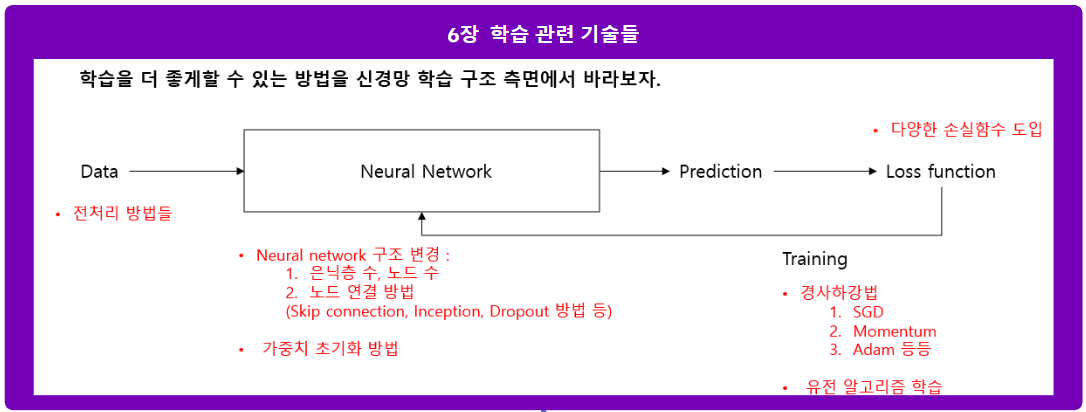


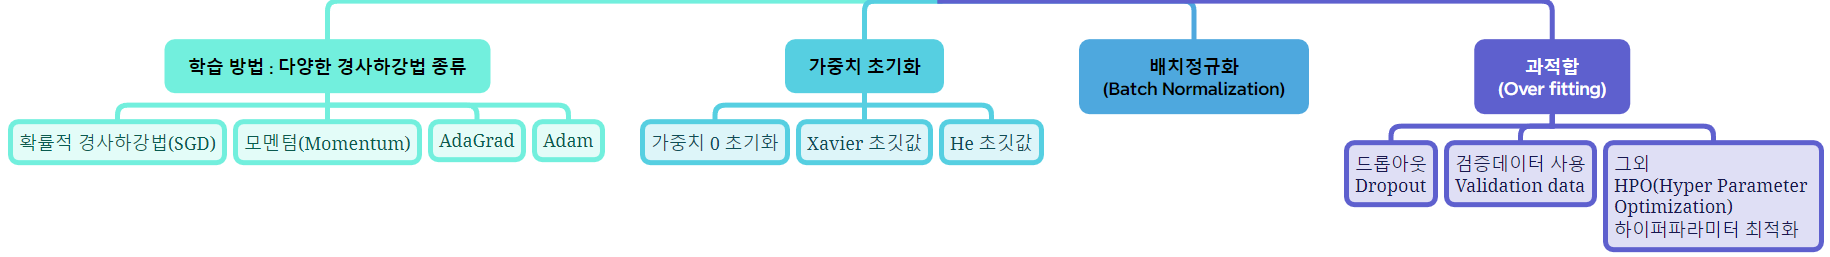

## 6.1 매개변수 갱신

- 기본적인 신경망의 학습 방법은 손실함수를 작게하는 매개변수인 가중치, 절편을 찾는 문제로 귀결되었음
- 이러한 문제를 푸는 것을 "최적화" Optimization 이라고 함
- 경사하강법으로 심층신경망을 학습하는 방법은 최적화에서 가장 좋은 해인 Global optimal을 찾아준다는 보장이 없음
- 데이터, 신경망 구조, 손실함수의 복합적인 형태에 따라 손실함수는 일반적으로 Global optimal을 보장하지 못하는 non-convex optimization probelm임

#### 근본적인 질문 :
1. 학습하는 방법이 경사하강법 방법말고 다른 새로운 학습 방법은 없을까?
2. 경사하강법을 좀 더 개선한 좋은 경사하강 방법들이 없을까?

### 6.1.2. 확률적 경사하강법(Stochastically Gradient Descent method)

- 컴퓨터 메모리가 많은 데이터를 한 번에 미분을 구하여 처리하기 어려울 때, 일부 데이터를 랜덤하게 선택하여 업데이트하는 방법임.
1. Full batch Gradient descent method : 데이터 전부에 대해 경사하강법 수행
2. Mini batch Gradient descent method : 데이터 일부에 대해 경사하강법 수행
3. Stochastically Gradient descent method : 데이터 1개에 대해 경사하강법 수행

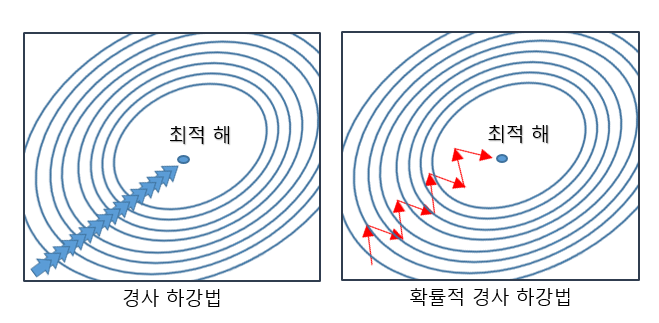
- 출처 : https://kerpect.tistory.com/183

- SGD의 장점: Full batch에 대한 손실함수에서 local optimal을 빠져나올 수 있는 가능성을 가짐.
- SGD의 단점: Full batch 모든 데이터에 대한 손실함수 미분값을 한 번에 반영하지 않음. -> 이 때문에 에폭에 따른 손실함수 그래프를 보면 손실함수가 오히려 증가하는 경우가 생길 가능성이 있음
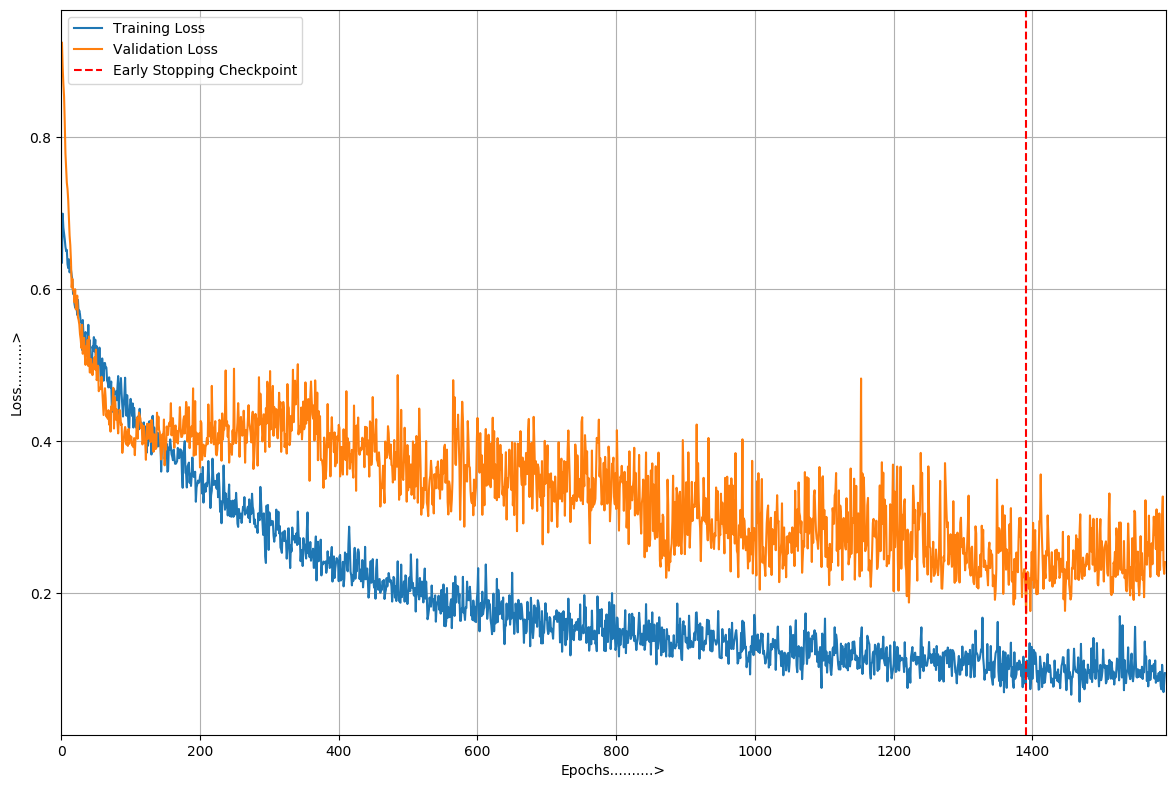

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [4]:
def one_hot_encode(t, num_classes):
    num_samples = t.shape[0]
    one_hot_labels = np.zeros((num_samples, num_classes))
    one_hot_labels[np.arange(num_samples), t] = 1
    return one_hot_labels

- MNIST 데이터셋 불러오기

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

#from two_layer_net import TwoLayerNet
from common import *
from tensorflow.keras.datasets import mnist


(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
t_train = one_hot_encode(t=t_train, num_classes=10)
t_test = one_hot_encode(t=t_test, num_classes=10)

print(np.shape(x_train))
print(np.shape(t_train))
print(np.shape(x_test))
print(np.shape(t_test))

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


- min max 정규화

In [6]:
x_train = x_train / 255
x_test = x_test/ 255

- Optimizer로 SGD 선언

In [7]:
optimizer = SGD()

In [8]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

print("신경망 학습시작 ")
print("=======================================================")
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    """
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    """
    optimizer.update(network.params, grad)
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

신경망 학습시작 
0.141 0.1466
0.43703333333333333 0.4436
0.7799833333333334 0.7872
0.84615 0.8517
0.8738666666666667 0.8794
0.8853166666666666 0.8904
0.8912333333333333 0.895
0.8961166666666667 0.8994
0.9005833333333333 0.9043
0.9038333333333334 0.907
0.9068833333333334 0.911
0.91005 0.9135
0.91145 0.9146
0.9130666666666667 0.9166
0.9163833333333333 0.92
0.9181333333333334 0.92
0.9193333333333333 0.9223


### 6.1.3. SGD의 단점
- $f(x,y)=\frac {1} {20} x^2 + y^2 $
- 위와 같이 x 축으로 완만한 기울기를 가지는 공간에서 SGD 학습은 문제가 될 수 있음

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


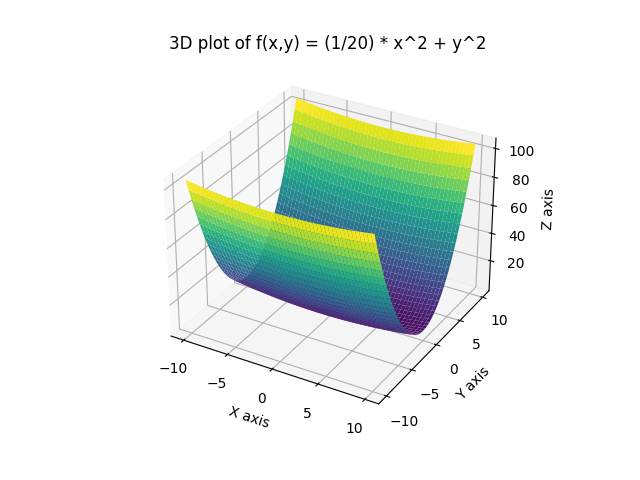

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return (1/20) * x**2 + y**2

# Generate the data points
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, z, cmap='viridis')

# Add labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D plot of f(x,y) = (1/20) * x^2 + y^2')

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


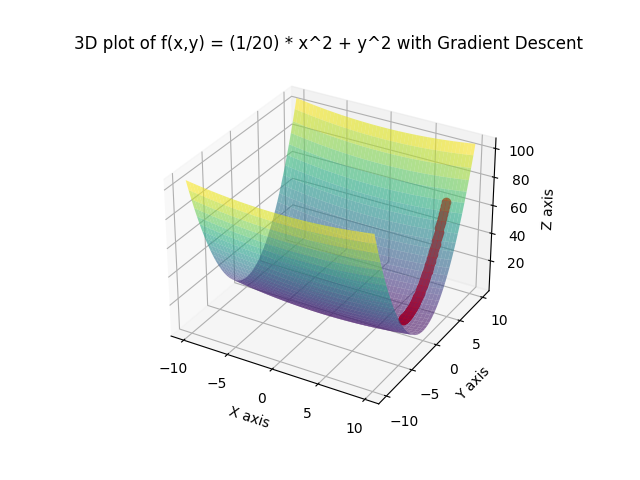

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return (1/20) * x**2 + y**2

# Define the gradient of the function
def grad_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return np.array([df_dx, df_dy])

# Gradient descent parameters
learning_rate = 0.01
num_iterations = 100

# Starting point for gradient descent
x0, y0 = 8.0, 8.0  # You can change this starting point if you want
points = [(x0, y0)]

# Perform gradient descent
for _ in range(num_iterations):
    grad = grad_f(x0, y0)
    x0 -= learning_rate * grad[0]
    y0 -= learning_rate * grad[1]
    points.append((x0, y0))

# Generate the data points for the surface plot
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.6)

# Add labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D plot of f(x,y) = (1/20) * x^2 + y^2 with Gradient Descent')

# Plot gradient descent points
points = np.array(points)
ax.plot(points[:, 0], points[:, 1], f(points[:, 0], points[:, 1]), 'ro-')

# Show the plot
plt.show()


- 위처럼 x=0,y=0 점이 global optimal 이지만 가지 못하고 끝나는 것을 볼 수가 있음.
- 이는 x축의 경사가 너무 완만해서 발생하는 현상임

### 6.1.4. 모멘텀(Momentum)

- 모멘텀은 "운동량" 을 나타내는 의미로 공이 경사진 곳에 굴러갈 때 가속도가 붙어 가는 개념을 경사하강법에 반영한 방법임.

- $ \mathbf{v} \leftarrow \alpha \mathbf{v}-\eta \frac {\partial L} {\partial W}$ : 편미분 반대 방향으로의 가속도
- $W \leftarrow W + \mathbf{v}$ : 가속도를 반영한 파라미터 업데이트

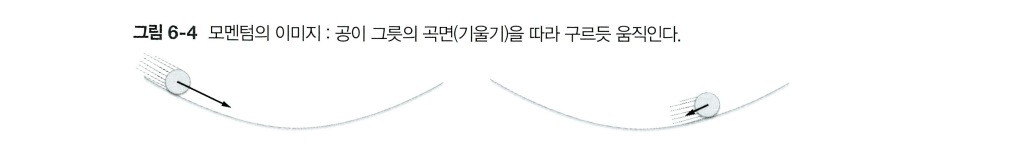

In [12]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None :
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum* self.v[key] - self.lr* grads[key]
            params[key] += self.v[key]

<IPython.core.display.Javascript object>


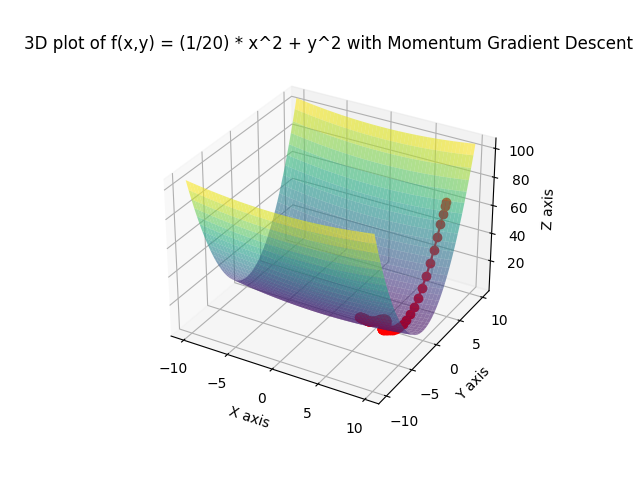

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return (1/20) * x**2 + y**2

# Define the gradient of the function
def grad_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return np.array([df_dx, df_dy])

# Gradient descent parameters
learning_rate = 0.01
momentum = 0.9
num_iterations = 100

# Starting point for gradient descent
x0, y0 = 8.0, 8.0  # You can change this starting point if you want
points = [(x0, y0)]

# Initialize the velocity
velocity = np.array([0.0, 0.0])

# Perform gradient descent with momentum
for _ in range(num_iterations):
    grad = grad_f(x0, y0)
    velocity = momentum * velocity - learning_rate * grad
    x0 += velocity[0]
    y0 += velocity[1]
    points.append((x0, y0))

# Generate the data points for the surface plot
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.6)

# Add labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D plot of f(x,y) = (1/20) * x^2 + y^2 with Momentum Gradient Descent')

# Plot gradient descent points
points = np.array(points)
ax.plot(points[:, 0], points[:, 1], f(points[:, 0], points[:, 1]), 'ro-')

# Show the plot
plt.show()


- 위에는 모멘텀을 경사하강법 대신 사용한 경우의 결과임.
- 결과를 보면 경사하강법보다 같은 업데이트 횟수에서 좀 더 global optimal에 가까운 것을볼 수 있음

- 모멘텀을 사용하여 MNIST 숫자이미지 신경망 학습

In [14]:
optimizer = Momentum()

In [15]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

print("신경망 학습시작 ")
print("=======================================================")
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    """
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    """
    optimizer.update(network.params, grad)
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

신경망 학습시작 
0.09296666666666667 0.0923
0.9045 0.9079
0.9234 0.9256
0.9355833333333333 0.9371
0.9413833333333333 0.9408
0.94735 0.9458
0.9520166666666666 0.9488
0.9556833333333333 0.9531
0.9585333333333333 0.9551
0.9628166666666667 0.9591
0.9634 0.9608
0.9656333333333333 0.9604
0.9693166666666667 0.9633
0.9708833333333333 0.9641
0.97285 0.9642
0.9742166666666666 0.9646
0.9747833333333333 0.9651


- 아래는 SGD를 사용하여 학습한 신경망에 대한 Train, Test 데이터 정확도
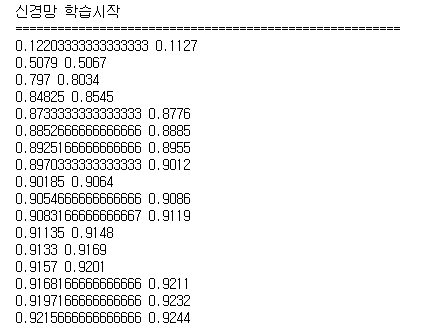

- 실험결과를 보면
1. 모멘텀을 사용한 경우 : 97.85% Train data 정확도
2. SGd를 사용한 경우 : 92.15% Train data 정확도
- 즉 더 좋은 해를 찾은 것으로 해석할 수 있음

### 6.1.5 AdaGrad

- 우리는 이때까지 학습률 $\eta $ 혹은 $\rho $ 를 하이퍼 파라미터, 즉 0.001 정도로 사용하였음.
- 학습률 값이 너무 작으면 학습이 느리고, 학습률 값이 너무 크면 손실함수 값이 발산할 위험이 있음.


- AdaGrad는 학습률을 신경망 학습에 맞게 정해보는 방법으로 학습률을 점차 줄여가는 방법을 사용함
- 여기서 중요한 포인트는 학습률을 조정할 때 편미분 각 원소마다 학습률을 다르게 조정하는 방식임

AdaGrad
- $\mathbf{h} \leftarrow \mathbf{h} + \frac {\partial L} {\partial W} \odot \frac {\partial L} {\partial W} $ : 가중치를 얼마나 감소시킬지 정하는 값
- 
- $ W \leftarrow W - \eta \frac {1} {\sqrt{\mathbf{h}}} \frac {\partial L } {\partial W} $ : 파라미터 업데이트 식

해석 :
- 편미분 $\frac {\partial L} {\partial W}$값이 클수록 $\mathbf{h}$ 값이 커짐
- $\mathbf{h}$ 값이 크면$ \frac {1} {\sqrt{\mathbf{h}}}$ 값은 작아진다는 의미임
- 반대로 편미분 $\frac {\partial L} {\partial W}$값이 작으면 $\mathbf{h}$ 값이 작아지고 $ \frac {1} {\sqrt{\mathbf{h}}}$ 값은 커진다는 의미임
- 즉 편미분 원소에서 기울기가 큰 파라미터는 점점 작게 움직이고, 반대로 기울기가 작은 파라미터는 크게 움직이는 의미임

In [16]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr= lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None :
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

<IPython.core.display.Javascript object>


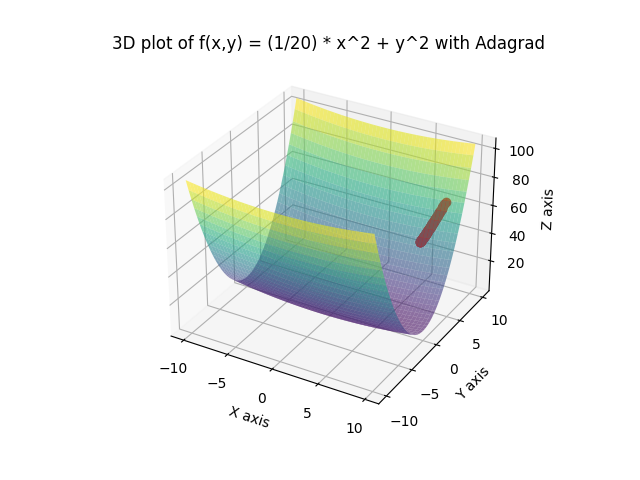

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return (1/20) * x**2 + y**2

# Define the gradient of the function
def grad_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return np.array([df_dx, df_dy])

# Gradient descent parameters
learning_rate = 0.1
epsilon = 1e-8
num_iterations = 100

# Starting point for gradient descent
x0, y0 = 8.0, 8.0  # You can change this starting point if you want
points = [(x0, y0)]

# Initialize the sum of squared gradients
grad_squared_sum = np.array([0.0, 0.0])

# Perform gradient descent with Adagrad
for _ in range(num_iterations):
    grad = grad_f(x0, y0)
    grad_squared_sum += grad**2
    adjusted_learning_rate = learning_rate / (np.sqrt(grad_squared_sum) + epsilon)
    x0 -= adjusted_learning_rate[0] * grad[0]
    y0 -= adjusted_learning_rate[1] * grad[1]
    points.append((x0, y0))

# Generate the data points for the surface plot
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.6)

# Add labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D plot of f(x,y) = (1/20) * x^2 + y^2 with Adagrad')

# Plot gradient descent points
points = np.array(points)
ax.plot(points[:, 0], points[:, 1], f(points[:, 0], points[:, 1]), 'ro-')

# Show the plot
plt.show()


- 위와 같은 경우 수렴하지 않는 것을 볼 수 있는데 이를 개선한 방법이 RMSProp 방법이 있음

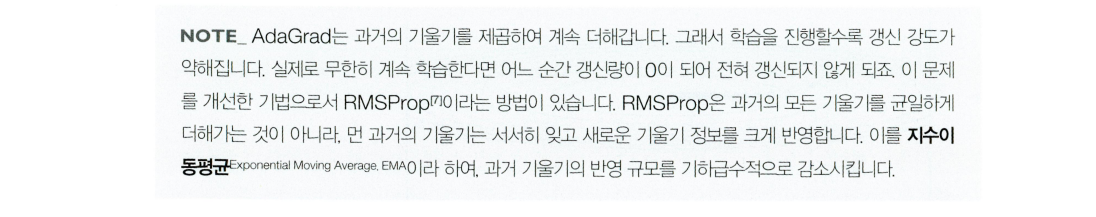

## 
- AdaGrad 사용하여 MNIST 숫자이미지 신경망 학습

In [18]:
optimizer = AdaGrad()

In [19]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

print("신경망 학습시작 ")
print("=======================================================")
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    """
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    """
    optimizer.update(network.params, grad)
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

신경망 학습시작 
0.1353 0.1343
0.9134166666666667 0.9165
0.9254 0.9261
0.9321333333333334 0.9332
0.9356 0.9367
0.9380166666666667 0.939
0.9406833333333333 0.9407
0.9424833333333333 0.9421
0.9445 0.9427
0.9460333333333333 0.9446
0.9474 0.9447
0.9483 0.9471
0.9494166666666667 0.9474
0.9504166666666667 0.948
0.9514166666666667 0.9493
0.9522 0.9505
0.9528166666666666 0.9504


- 실험결과 :
1. 모멘텀을 사용한 경우 : 97.85% Train data 정확도
2. SGd를 사용한 경우 : 92.15% Train data 정확도
3. AdaGrad 를 사용한 경우 : 95.59% Train data 정확도

### 6.1.6 Adam

- 직관적으로 모멘텀과 AdaGrad를 융합한 방법

In [20]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### 
- 다양한 경사하강법 종류들

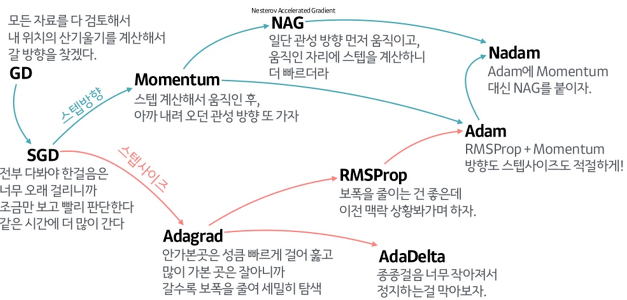
- 출처 : https://www.slideshare.net/yongho/ss-79607172 

### 6.1.8 MNIST 데이터셋에 대한 4가지 옵티마이저 기법 비교

In [4]:
def one_hot_encode(t, num_classes):
    num_samples = t.shape[0]
    one_hot_labels = np.zeros((num_samples, num_classes))
    one_hot_labels[np.arange(num_samples), t] = 1
    return one_hot_labels

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

#from two_layer_net import TwoLayerNet
from common import *
from tensorflow.keras.datasets import mnist


(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
t_train = one_hot_encode(t=t_train, num_classes=10)
t_test = one_hot_encode(t=t_test, num_classes=10)

print(np.shape(x_train))
print(np.shape(t_train))
print(np.shape(x_test))
print(np.shape(t_test))

x_train = x_train / 255
x_test = x_test/ 255

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [11]:
from common import optimizer
# 학습 설정
input_size = 784
hidden_size = 50
output_size = 10
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 각 옵티마이저 별로 학습을 수행하고, 손실 값을 저장합니다.
optimizers = {
    'SGD':optimizer.SGD(lr=learning_rate),
    'Momentum': optimizer.Momentum(lr=learning_rate, momentum=0.9),
    'AdaGrad': optimizer.AdaGrad(lr=learning_rate),
    'Adam': optimizer.Adam(lr=learning_rate)
}

loss_dict = {key: [] for key in optimizers.keys()}

for optimizer_name, optimizer in optimizers.items():
    # 신경망 초기화
    network = TwoLayerNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    print(f"{optimizer_name} 학습 시작")
    print("="*50)
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        # 기울기 계산
        grad = network.gradient(x_batch, t_batch)
        
        # 갱신
        optimizer.update(network.params, grad)
        
        loss = network.loss(x_batch, t_batch)
        loss_dict[optimizer_name].append(loss)
        
        if i % (iters_num // 10) == 0:
            print(f"Iteration {i}/{iters_num}, Loss: {loss:.4f}")


SGD 학습 시작
Iteration 0/10000, Loss: 2.3018
Iteration 1000/10000, Loss: 0.1887
Iteration 2000/10000, Loss: 0.1610
Iteration 3000/10000, Loss: 0.0473
Iteration 4000/10000, Loss: 0.1469
Iteration 5000/10000, Loss: 0.0902
Iteration 6000/10000, Loss: 0.0424
Iteration 7000/10000, Loss: 0.0891
Iteration 8000/10000, Loss: 0.0987
Iteration 9000/10000, Loss: 0.0436
Momentum 학습 시작
Iteration 0/10000, Loss: 2.3012
Iteration 1000/10000, Loss: 0.0233
Iteration 2000/10000, Loss: 0.1127
Iteration 3000/10000, Loss: 0.1076
Iteration 4000/10000, Loss: 0.0703
Iteration 5000/10000, Loss: 0.0387
Iteration 6000/10000, Loss: 0.0151
Iteration 7000/10000, Loss: 0.0076
Iteration 8000/10000, Loss: 0.0480
Iteration 9000/10000, Loss: 0.0275
AdaGrad 학습 시작
Iteration 0/10000, Loss: 7.9728
Iteration 1000/10000, Loss: 0.1330
Iteration 2000/10000, Loss: 0.0730
Iteration 3000/10000, Loss: 0.0726
Iteration 4000/10000, Loss: 0.0291
Iteration 5000/10000, Loss: 0.0361
Iteration 6000/10000, Loss: 0.0297
Iteration 7000/10000, Los

- 4개 옵티마이저 학습 그래프 시각화

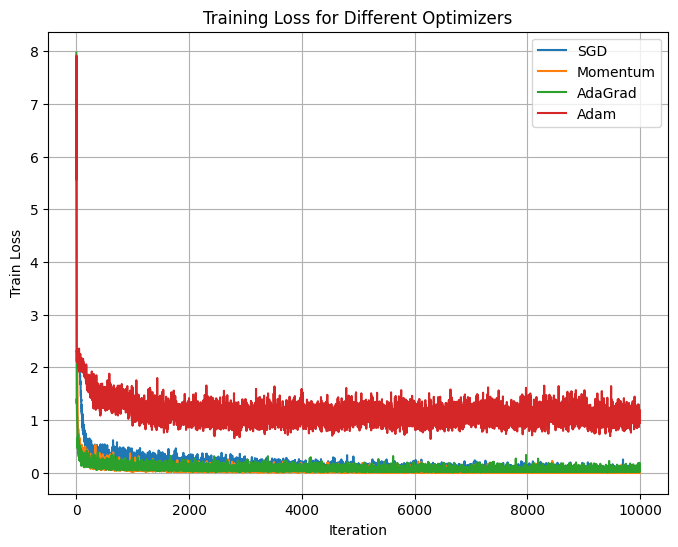

In [12]:
# 각 옵티마이저 별 학습 손실 그래프를 그립니다.
plt.figure(figsize=(8, 6))
for optimizer_name, losses in loss_dict.items():
    plt.plot(losses, label=optimizer_name)

plt.xlabel('Iteration')
plt.ylabel('Train Loss')
plt.title('Training Loss for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

### 정리
- 신경망을 학습하는 방법으로 파라미터(가중치, 절편)를 사용하여 손실함수를 감소하는 경사하강법을 선택하고 있음.
- 다양한 옵티마이저 방법론들이 있고 상황에 맞게 사용해보는 것이 중요함.
- 내가 다루는 데이터에 따라, 신경망의 구조에 따라, 손실함수에 따라 어떤 옵티마이저를 선택하는 것이 좋은가?
- 새로운 옵티마이저를 만들어볼 수 있는가?